In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/nlp/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/nlp/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/nlp/names\\Arabic.txt', 'data/nlp/names\\Chinese.txt', 'data/nlp/names\\Czech.txt', 'data/nlp/names\\Dutch.txt', 'data/nlp/names\\English.txt', 'data/nlp/names\\French.txt', 'data/nlp/names\\German.txt', 'data/nlp/names\\Greek.txt', 'data/nlp/names\\Irish.txt', 'data/nlp/names\\Italian.txt', 'data/nlp/names\\Japanese.txt', 'data/nlp/names\\Korean.txt', 'data/nlp/names\\Polish.txt', 'data/nlp/names\\Portuguese.txt', 'data/nlp/names\\Russian.txt', 'data/nlp/names\\Scottish.txt', 'data/nlp/names\\Spanish.txt', 'data/nlp/names\\Vietnamese.txt']
Slusarski


In [6]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Turning Names into Tensors

In [7]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [8]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [10]:
n_letters

57

In [9]:
print(rnn)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [12]:
letterToIndex('A'), letterToTensor('A')

(26,
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]]))

In [15]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9655, -2.8717, -2.8842, -2.7883, -2.7554, -2.9501, -2.9165, -2.8196,
         -2.9953, -2.9469, -2.9901, -2.8898, -2.8581, -2.9571, -2.8214, -2.8468,
         -3.0233, -2.7997]], grad_fn=<LogSoftmaxBackward>)


In [16]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('English', 4)


In [17]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Strilakos
category = English / line = Forde
category = English / line = Odell
category = Italian / line = Gatti
category = Italian / line = Bianchi
category = Chinese / line = Zhen
category = Polish / line = Stolarz
category = English / line = Crossley
category = Spanish / line = Gallego
category = Korean / line = Ngai


In [18]:
criterion = nn.NLLLoss()

In [19]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [22]:
randomTrainingExample()

('Czech',
 'Tikal',
 tensor([2]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [20]:
import time
import math

n_iters = 1000
print_every = 50
plot_every = 10



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

50 5% (0m 1s) 2.7414 So / Korean ✓
100 10% (0m 1s) 2.8581 Stavropoulos / Korean ✗ (Greek)
150 15% (0m 1s) 2.9972 Malouf / Czech ✗ (Arabic)
200 20% (0m 1s) 2.8172 Jans / Czech ✗ (German)
250 25% (0m 2s) 2.9858 Shirasu / Russian ✗ (Japanese)
300 30% (0m 2s) 2.7861 Hay / Czech ✗ (Scottish)
350 35% (0m 2s) 2.8338 Wellman / Scottish ✗ (English)
400 40% (0m 2s) 2.9082 Guerin / Scottish ✗ (French)
450 45% (0m 2s) 2.8013 Badukin / Scottish ✗ (Russian)
500 50% (0m 2s) 2.9351 Phan / Scottish ✗ (Vietnamese)
550 55% (0m 2s) 2.7570 Choe / Korean ✓
600 60% (0m 2s) 2.7952 Minovitzky / Scottish ✗ (Russian)
650 65% (0m 2s) 2.8619 Damhain / Scottish ✗ (Irish)
700 70% (0m 2s) 2.9105 Zoucha / Japanese ✗ (Czech)
750 75% (0m 2s) 2.9239 Starek / Russian ✗ (Polish)
800 80% (0m 2s) 2.7286 Glynatsis / Greek ✓
850 85% (0m 3s) 2.7951 Yeo / English ✗ (Korean)
900 90% (0m 3s) 2.9421 Leitz / Chinese ✗ (German)
950 95% (0m 3s) 2.9832 Chavez / Polish ✗ (Spanish)
1000 100% (0m 3s) 2.7887 Sokolsky / Scottish ✗ (Polish)


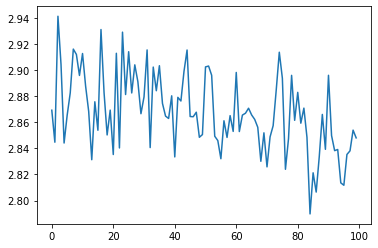

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)